In [1]:
import sys
import os


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
   sys.path.append(module_path)


In [2]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from dataclasses import dataclass


In [3]:
from dataset_splitter.structs.MapSatellite import MapSatellite
from dataset_splitter.AbstractGenerator import (
    PixelBoundingBox,
    Tile,
    UTMCoordinates,
    UTMPatchCoordinates,
    AbstractGenerator,
)
from resnet_train import PipelineConfig

In [4]:
def map_df_to_tiles(filtered_df):
    tiles_list: List[Tile] = []
    for index, row in filtered_df.iterrows():
        # Handle potential string/float mismatch in zone
        zone = str(row.get("zone_utm", "50R")) 
        
        utm_coords = UTMCoordinates(
            e=float(row["e_utm"]), 
            n=float(row["n_utm"]), 
            zone=zone
        )
        tile_obj = Tile(
            id=index,
            utm_centroid=utm_coords,
            width=int(row.get("width", 224)),   # Default 224 if missing
            height=int(row.get("height", 224)),
            friendly_name=row["friendly-name"],
            place_id="0",
            img_path=row.get("img_path", ""),
        )
        tiles_list.append(tile_obj)
    return tiles_list

In [5]:
def get_bounding_box_for_picture(tile, lt_utm_sat, meters_per_pixel_x, meters_per_pixel_y):
    # Calculate distance from Map Top-Left (in meters)
    e_meters_pic = abs(lt_utm_sat.e - tile.utm_centroid.e)
    n_meters_pic = abs(lt_utm_sat.n - tile.utm_centroid.n)

    # Convert to pixels
    centroid_pixel_x = e_meters_pic / meters_per_pixel_x
    centroid_pixel_y = n_meters_pic / meters_per_pixel_y

    width = tile.width
    height = tile.height

    # Force size for UAV visualization
    if "uav" in tile.friendly_name.lower():
        width = 100
        height = 100

    box_top_left_x = centroid_pixel_x - width / 2
    box_top_left_y = centroid_pixel_y - height / 2
    box_bottom_right_x = centroid_pixel_x + width / 2
    box_bottom_right_y = centroid_pixel_y + height / 2

    m_width = abs(box_bottom_right_x - box_top_left_x) * meters_per_pixel_x
    m_height = abs(box_bottom_right_y - box_top_left_y) * meters_per_pixel_y

    return PixelBoundingBox(
        lt_x=box_top_left_x,
        lt_y=box_top_left_y,
        rb_x=box_bottom_right_x,
        rb_y=box_bottom_right_y,
        m_width=m_width,
        m_height=m_height,
        id=tile.id,
    )

In [17]:
def get_random_uav_and_neighbors(df_tiles, top_n: int = 5) -> pd.DataFrame:
    """
    Selects one random UAV tile as a query and finds its nearest neighbors.
    """
    # 1. Filter only UAV records
    uav_records = df_tiles[
        df_tiles["friendly-name"].str.contains("uav", case=False, na=False)
    ].copy()

    if uav_records.empty:
        print("No UAV records found in DataFrame.")
        return pd.DataFrame()

    # 2. Select ONE random query row
    query_row = uav_records.sample(1)
    
    # Extract coordinates
    # We use UTM coordinates from CSV to calculate geometric distance for visualization
    all_coords = uav_records[["e_utm", "n_utm"]].to_numpy()
    query_coords = query_row[["e_utm", "n_utm"]].to_numpy()

    print(f"Randomly selected Query Index: {query_row.index[0]}")
    print(f"Query Name: {query_row['friendly-name'].values[0]}")

    # 3. Find Nearest Neighbors
    # We look for top_n + 1 because the query point itself is included (distance 0)
    real_k = min(top_n + 1, len(uav_records))
    
    nn_model = NearestNeighbors(n_neighbors=real_k, algorithm="kd_tree")
    nn_model.fit(all_coords)

    distances, indices = nn_model.kneighbors(query_coords)

    # Flatten the results
    distances = distances[0]
    indices = indices[0]

    # 4. Fetch the resulting rows
    # Note: iloc is used on uav_records because indices are relative to that filtered dataframe
    result_df = uav_records.iloc[indices].copy()
    
    # Add distance for reference
    result_df["nn_distance_to_neighbor"] = distances

    # Sort so the Query (distance 0.0) is first
    result_df = result_df.sort_values(by="nn_distance_to_neighbor")

    print(f"Found {len(result_df)} records (Query + Neighbors):")
    for _, row in result_df.iterrows():
        print(f" > Index: {row.name} | Dist: {row['nn_distance_to_neighbor']:.2f}m | {row['friendly-name']}")

    return result_df

In [ ]:
def calculate_pixel_resolution_from_tif(map_path, coords_csv_path, region_name):
    with rasterio.open(map_path) as src:
        width_px = src.width
        height_px = src.height
        print(f"Map Image Size: {width_px} x {height_px} px")

    df_coords = pd.read_csv(coords_csv_path)
    
    row = df_coords[df_coords['mapname'].str.contains(region_name, na=False)].iloc[0]
    
    lt_lat, lt_lon = row['LT_lat_map'], row['LT_lon_map']
    rb_lat, rb_lon = row['RB_lat_map'], row['RB_lon_map']

    proj_wgs84 = Proj(proj='latlong', datum='WGS84')
    proj_utm = Proj(proj='utm', zone=50, datum='WGS84', north=True)

    lt_e, lt_n = transform(proj_wgs84, proj_utm, lt_lon, lt_lat)
    rb_e, rb_n = transform(proj_wgs84, proj_utm, rb_lon, rb_lat)

    width_meters = abs(rb_e - lt_e)
    height_meters = abs(lt_n - rb_n)

    res_x = width_meters / width_px
    res_y = height_meters / height_px

    lt_utm_sat = UTMCoordinates(e=lt_e, n=lt_n, zone="50S") 

    print(f"Calculated Resolution: {res_x:.4f} m/px (X), {res_y:.4f} m/px (Y)")
    return lt_utm_sat, res_x, res_y

In [8]:
def quick_load_map_satellite(config: PipelineConfig, d_conf: dict) -> MapSatellite:
    region_name = d_conf["region_name"]

    output_csv_path = config.DATAFRAMES_ONE_TO_ONE_DIR / f"{region_name}.csv"
    
    map_tif_path = (
        config.UAV_VISLOC_ROOT
        / d_conf["uav_visloc_id"]
        / d_conf["map_filename"]
    )
    
    satellite_coords_csv = str(
        config.UAV_VISLOC_ROOT / "satellite_ coordinates_range.csv"
    )
    
    friendly_name = f"visloc-{region_name}-{d_conf['uav_visloc_id']}-satellite"

    map_sat = MapSatellite(
        csv_path=satellite_coords_csv,
        tiles_satellite_csv_output_path=str(output_csv_path),
        map_tif_path=str(map_tif_path),
        region_name=region_name,
        friendly_name=friendly_name,
    )
    
    print(f"Loaded for: {region_name}")
    return map_sat

In [9]:
def find_nearest_uav_tiles(csv_path, n_neighbors=5):
    df_tiles = pd.read_csv(csv_path)
    
    uav_records = df_tiles[
        df_tiles["friendly-name"].str.contains("uav", case=False, na=False)
    ].copy()

    if uav_records.empty:
        raise ValueError("No records with 'uav' in friendly-name found.")

    database_coords = uav_records[["e_utm", "n_utm"]].to_numpy()
    
    nn_model = NearestNeighbors(
        n_neighbors=min(n_neighbors + 1, len(database_coords)),
        algorithm="kd_tree"
    )
    nn_model.fit(database_coords)

    valid_indices = uav_records.index.tolist()
    random_idx = random.choice(valid_indices)
    
    query_row = uav_records.loc[[random_idx]]
    query_coords = query_row[["e_utm", "n_utm"]].to_numpy()

    print(f"--- Randomly selected QUERY point ---\nIndex: {random_idx}\nName: {query_row['friendly-name'].values[0]}")

    distances, indices = nn_model.kneighbors(query_coords)
    
    distances = distances[0]
    indices = indices[0]

    top_n_records = uav_records.iloc[indices].copy()
    top_n_records['nn_distance_to_neighbor'] = distances
    top_n_records = top_n_records.sort_values(by="nn_distance_to_neighbor")

    print(f"\nFound {len(top_n_records)} points (including query):")
    for idx, row in top_n_records.iterrows():
        print(f" > Org Index: {idx} | Distance: {row['nn_distance_to_neighbor']:.2f}m | {row['friendly-name']}")

    return top_n_records

In [23]:
def draw_boxes_on_map(filtered_df, satellite_map, lt_utm_sat, meters_per_pixel_x, meters_per_pixel_y):
    """
    Draws bounding boxes for filtered DataFrame on a cropped satellite map.
    """
    if filtered_df is None or filtered_df.empty:
        print("Error: DataFrame for drawing is empty.")
        return

    tiles_list = map_df_to_tiles(filtered_df)
    if not tiles_list:
        print("No tiles found after mapping.")
        return

    pixel_boxes_info = []
    for tile in tiles_list:
        # print(f"Processing: Index: {tile.id}")
        box = get_bounding_box_for_picture(
            tile, lt_utm_sat, meters_per_pixel_x, meters_per_pixel_y
        )
        pixel_boxes_info.append((box, tile.friendly_name, tile.img_path))

    if not pixel_boxes_info:
        print("No bounding boxes calculated.")
        return

    # --- CROP CALCULATION ---
    all_boxes = [b[0] for b in pixel_boxes_info]
    
    # Calculate global min/max for all boxes
    min_x = min([box.lt_x for box in all_boxes])
    max_x = max([box.rb_x for box in all_boxes])
    min_y = min([box.lt_y for box in all_boxes])
    max_y = max([box.rb_y for box in all_boxes])

    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    width_span = max_x - min_x
    height_span = max_y - min_y

    padding_x = max(500, width_span * 0.15)
    padding_y = max(500, height_span * 0.15)
    
    with rasterio.open(satellite_map.map_tif_path) as src:
        src_w, src_h = src.width, src.height

        # --- FIX: Clamp values to image boundaries ---
        crop_x_min = int(max(0, min_x - padding_x))
        crop_y_min = int(max(0, min_y - padding_y))
        
        crop_x_max = int(min(src_w, max_x + padding_x))
        crop_y_max = int(min(src_h, max_y + padding_y))
        
        window_width = crop_x_max - crop_x_min
        window_height = crop_y_max - crop_y_min
        
        print(f"Crop Size: {window_width}x{window_height} px")
        print(f"Center: ({center_x:.0f}, {center_y:.0f})")
        print(f"Number of boxes: {len(pixel_boxes_info)}")
        
        if window_width <= 0 or window_height <= 0:
            print(f"Error: Invalid crop dimensions. (W: {window_width}, H: {window_height})")
            print(f"Check if coordinates match the map area.")
            return
            
        window = Window(crop_x_min, crop_y_min, window_width, window_height)
        image_crop = src.read(window=window)
        
    image_crop = np.moveaxis(image_crop, 0, -1)
    if image_crop.shape[2] > 3:
        image_rgb = image_crop[:, :, :3]
    else:
        # Handle grayscale -> RGB
        if image_crop.shape[2] == 1:
            image_rgb = np.dstack([image_crop[:,:,0]]*3)
        else:
            image_rgb = image_crop
        
    # Image Normalization
    image_normalized = np.zeros_like(image_rgb, dtype=np.uint8)
    for i in range(image_rgb.shape[2]):
        band = image_rgb[:, :, i]
        p_low = np.percentile(band, 2)
        p_high = np.percentile(band, 98)
        band = np.clip(band, p_low, p_high)
        if p_high > p_low:
            band_normalized = ((band - p_low) / (p_high - p_low) * 255).astype(np.uint8)
        else:
            band_normalized = np.zeros_like(band, dtype=np.uint8)
        image_normalized[:, :, i] = band_normalized
        
    if image_normalized.ndim == 2:
        image_bgr = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2BGR)
    elif image_normalized.shape[2] == 3:
        image_bgr = cv2.cvtColor(image_normalized, cv2.COLOR_RGB2BGR)
    
    image_bgr = np.ascontiguousarray(image_bgr, dtype=np.uint8)
    
    # Draw Colors
    colors = [
        (0, 0, 255),    # Red
        (0, 255, 0),    # Green
        (255, 0, 0),    # Blue
        (255, 255, 0),  # Cyan
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Yellow
    ]
    
    thickness = 10 
    font_scale = 1.2

    VISUAL_EXPANSION_PX = 100
    
    for idx, (box, friendly_name, img_path) in enumerate(pixel_boxes_info):
        color = colors[idx % len(colors)]
        
        # Adjust coordinates relative to crop
        base_lt_x = box.lt_x - crop_x_min
        base_lt_y = box.lt_y - crop_y_min
        base_rb_x = box.rb_x - crop_x_min
        base_rb_y = box.rb_y - crop_y_min

        adj_lt_x = int(base_lt_x - VISUAL_EXPANSION_PX)
        adj_lt_y = int(base_lt_y - VISUAL_EXPANSION_PX)
        adj_rb_x = int(base_rb_x + VISUAL_EXPANSION_PX)
        adj_rb_y = int(base_rb_y + VISUAL_EXPANSION_PX)
        
        adj_lt_x = max(0, adj_lt_x)
        adj_lt_y = max(0, adj_lt_y)
        adj_rb_x = min(window_width, adj_rb_x)
        adj_rb_y = min(window_height, adj_rb_y)
        
        # Ensure drawing is within bounds (for text safety)
        if (0 <= adj_lt_x < window_width and 0 <= adj_lt_y < window_height):
            
            cv2.rectangle(image_bgr, (adj_lt_x, adj_lt_y), (adj_rb_x, adj_rb_y), color, thickness)
            
            # Label
            text = f"ID: {box.id}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 2)[0]
            
            cv2.rectangle(image_bgr,
                          (adj_lt_x, adj_lt_y - text_size[1] - 10),
                          (adj_lt_x + text_size[0], adj_lt_y),
                          color, -1)
            
            cv2.putText(image_bgr, text,
                        (adj_lt_x, adj_lt_y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale,
                        (255, 255, 255), 2)
            
            # Crosshair
            center_x_box = (adj_lt_x + adj_rb_x) // 2
            center_y_box = (adj_lt_y + adj_rb_y) // 2
            cross_size = 20
            
            cv2.line(image_bgr, (center_x_box - cross_size, center_y_box),
                     (center_x_box + cross_size, center_y_box), color, thickness)
            cv2.line(image_bgr, (center_x_box, center_y_box - cross_size),
                     (center_x_box, center_y_box + cross_size), color, thickness)
            
            print(f"  - Drawn box {box.id} ({friendly_name})")
            print(f"  - Path: \n {img_path}")
        else:
            print(f"  - Box {box.id} out of crop view!")
            
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(img_rgb)
    plt.title(f"Filtered UAV Images ({len(pixel_boxes_info)} shown)", fontsize=16)
    plt.axis('on')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== SUMMARY ===")
    print(f"Drawn {len(pixel_boxes_info)} boxes")
    print(f"Crop dimensions: {window_width}x{window_height} px")

Loaded for: Taizhou-1
Processing CSV file: /workspace/drone-loc-no-gps/Dataframes/one_to_one/Taizhou-1-one_to_one.csv
Map Image Size: 35092 x 24308 px
Calculated Resolution: 0.2581 m/px (X), 0.2878 m/px (Y)
Randomly selected Query Index: 81
Query Name: visloc-Taizhou-1-03-uav-03_0253.JPG-1
Found 4 records (Query + Neighbors):
 > Index: 81 | Dist: 0.00m | visloc-Taizhou-1-03-uav-03_0253.JPG-1
 > Index: 103 | Dist: 319.17m | visloc-Taizhou-1-03-uav-03_0322.JPG-1
 > Index: 79 | Dist: 378.86m | visloc-Taizhou-1-03-uav-03_0249.JPG-1
 > Index: 83 | Dist: 380.55m | visloc-Taizhou-1-03-uav-03_0257.JPG-1
Crop Size: 3488x2661 px
Center: (14778, 8521)
Number of boxes: 4


/tmp/ipykernel_83512/2354827545.py:27: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lt_e, lt_n = transform(proj_wgs84, proj_utm, lt_lon, lt_lat)
/tmp/ipykernel_83512/2354827545.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  rb_e, rb_n = transform(proj_wgs84, proj_utm, rb_lon, rb_lat)


  - Drawn box 81 (visloc-Taizhou-1-03-uav-03_0253.JPG-1)
  - Path: 
 /workspace/datasets/train_tiles_one_to_one/Taizhou-1/patch__32_33248966__119_8457539__54f6c74327cc4730a5f698cd72c3cfc7_1.jpg
  - Drawn box 103 (visloc-Taizhou-1-03-uav-03_0322.JPG-1)
  - Path: 
 /workspace/datasets/train_tiles_one_to_one/Taizhou-1/patch__32_33192817__119_8424307__9d3e1a6795e94a31b1e9165749604ac0_1.jpg
  - Drawn box 79 (visloc-Taizhou-1-03-uav-03_0249.JPG-1)
  - Path: 
 /workspace/datasets/train_tiles_one_to_one/Taizhou-1/patch__32_33039264__119_8489281__5f53e200d97c47ca90dfd2ae89ed9834_1.jpg
  - Drawn box 83 (visloc-Taizhou-1-03-uav-03_0257.JPG-1)
  - Path: 
 /workspace/datasets/train_tiles_one_to_one/Taizhou-1/patch__32_33458669__119_8425568__0c4762b21a6045eda4cc5f1f61ff9f7d_1.jpg


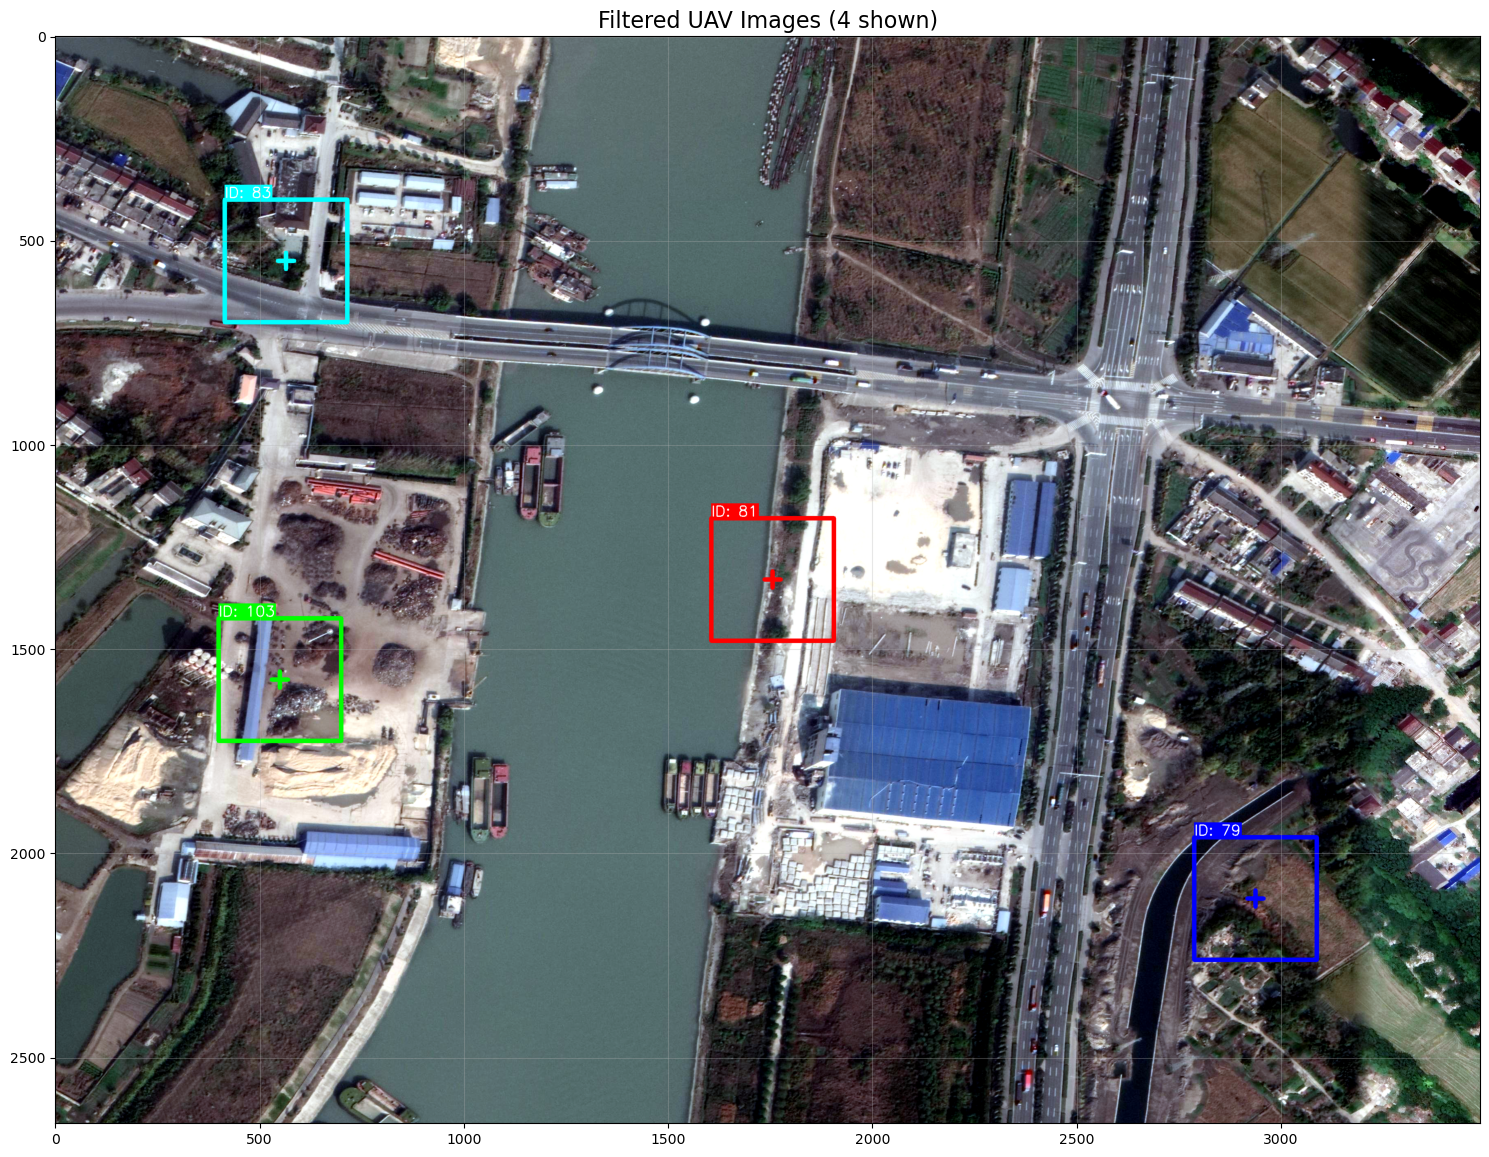


=== SUMMARY ===
Drawn 4 boxes
Crop dimensions: 3488x2661 px


In [24]:
import random
from pyproj import Proj, transform
config = PipelineConfig()
config.DATAFRAMES_ROOT.mkdir(parents=True, exist_ok=True)

DATA_CONFIG = [
    {
        "set_type": "train",
        "region_name": "Taizhou-1",
        "uav_visloc_id": "03",
        "map_filename": "satellite03.tif",
    }
]

target_config = DATA_CONFIG[0]

map_sat = quick_load_map_satellite(config, target_config)

# csv_file_path = map_sat.tiles_satellite_csv_output_path 
csv_path = "/workspace/drone-loc-no-gps/Dataframes/one_to_one/Taizhou-1-one_to_one.csv"

print(f"Processing CSV file: {csv_path}")

df_tiles = pd.read_csv(csv_path)


lt_utm_sat, res_x, res_y = calculate_pixel_resolution_from_tif(
    map_sat.map_tif_path, 
    map_sat.csv_path,
    target_config["map_filename"] # Using region name to find coords in CSV
)

# 3. Random Selection & Neighbors (New Logic)
# No radius needed anymore, just how many neighbors you want to see
top_n = 3 
top_records = get_random_uav_and_neighbors(df_tiles, top_n=top_n)

# 4. Drawing
try:
    draw_boxes_on_map(
        filtered_df=top_records, 
        satellite_map=map_sat, 
        lt_utm_sat=lt_utm_sat, 
        meters_per_pixel_x=res_x, 
        meters_per_pixel_y=res_y
    )
except Exception as e:
    print(f"CRITICAL ERROR: {e}")
    import traceback
    traceback.print_exc()

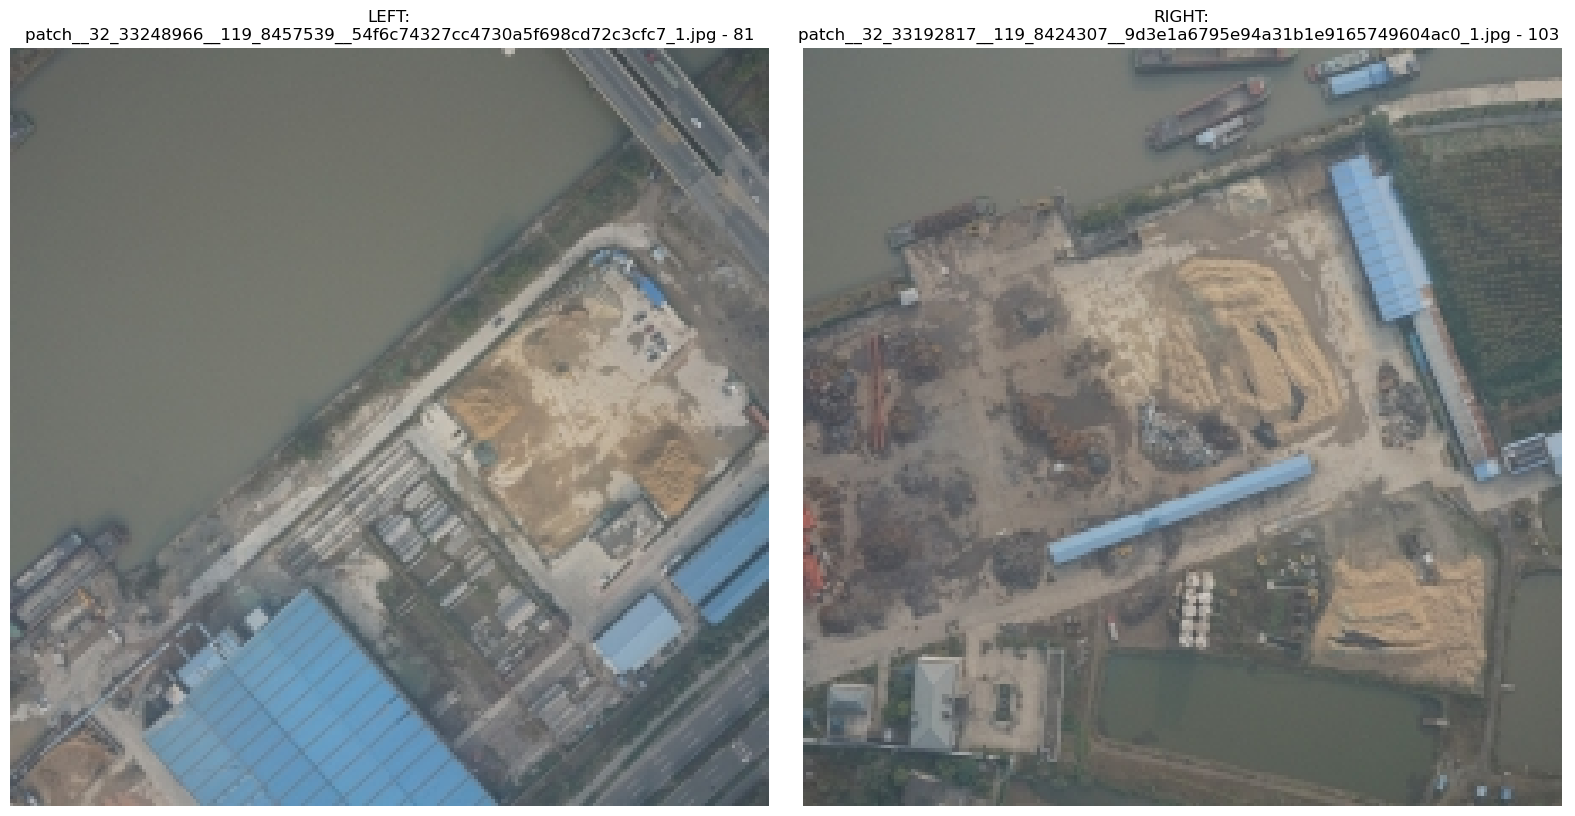

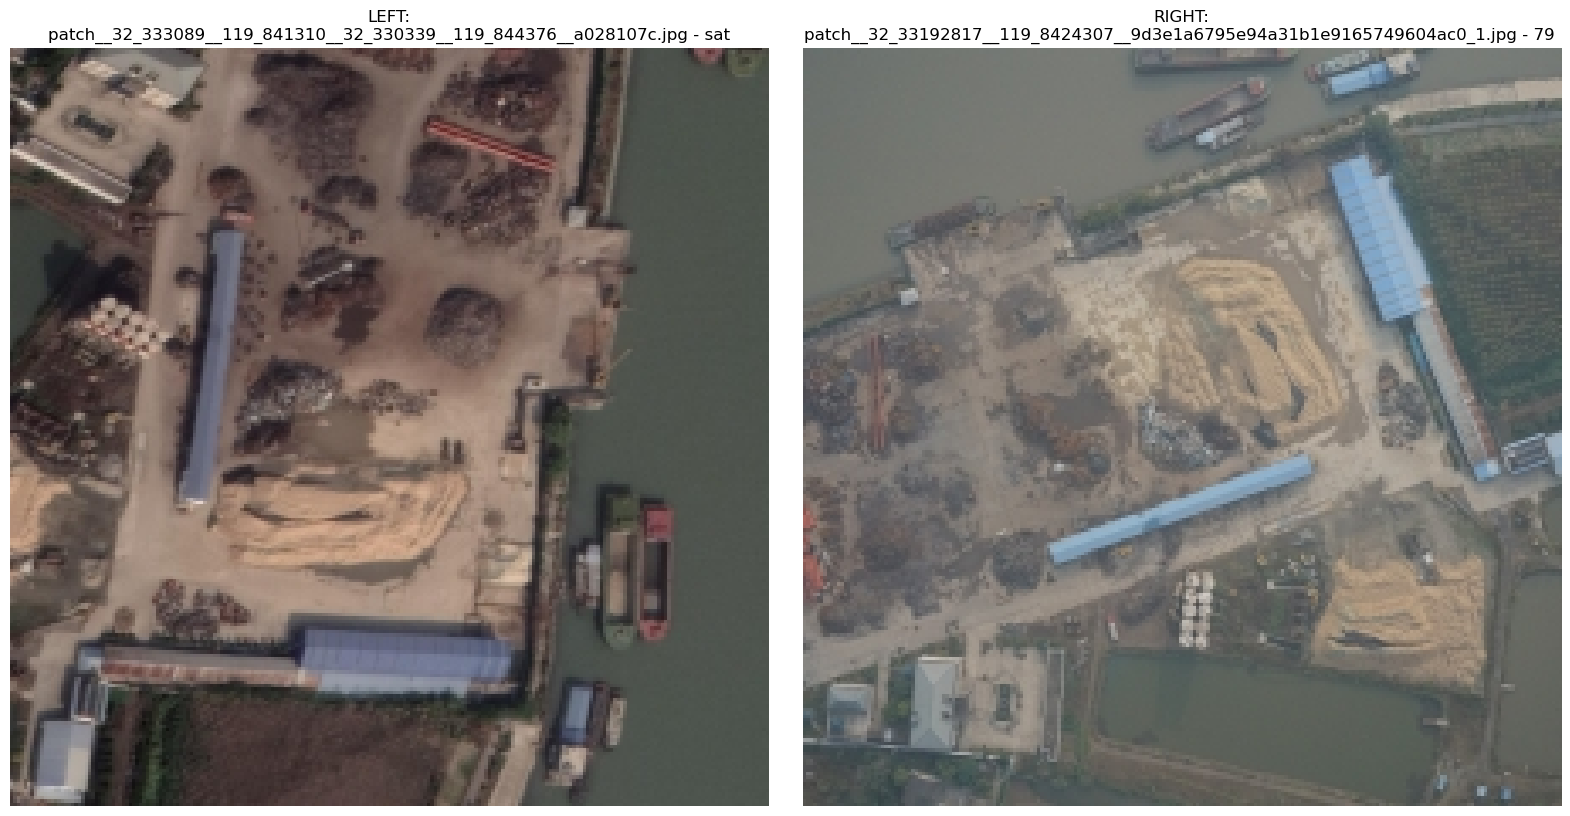